In [3]:
# importing required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.utils.vis_utils import plot_model
from IPython import display
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.txt",header=None)
index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/index.txt",header=None)
data = data.to_numpy()
index = index.to_numpy()

In [8]:
print(data.shape)
print(index.shape)
train_dataset = np.reshape(data,(-1,720,16,1))
print(train_dataset.shape)

(2246400, 16)
(6240, 2)
(3120, 720, 16, 1)


(720, 16, 1)


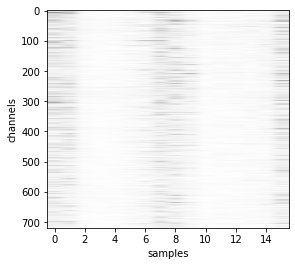

In [13]:
print(train_dataset[2].shape)
train_imgs = train_dataset
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(train_imgs[1000,:,:,0]),cmap='Greys')
plt.xlabel('samples')
plt.ylabel('channels')
ax.set_aspect(0.02)

In [15]:
N_Imag = 3120
Batch_Size = 24
train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(N_Imag).batch(Batch_Size)
noise_d = 200

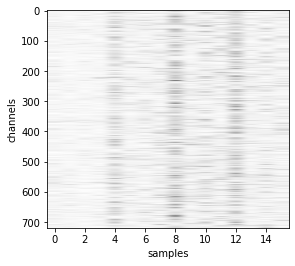

In [17]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    # First Layer (from noise 100x1 to 7*7*256)
    model.add(layers.Dense(4*180*64, use_bias=False, input_shape=(noise_d,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((180, 4, 64)))
    assert model.output_shape == (None, 180, 4, 64) 

    # Second Layer (1st Deconvolution)
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 180, 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Thirds Layer (2nd Deconvolution)
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 360, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 720, 16, 1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Forth Layer (3rd Deconvolution)
    #model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 16, 720, 1)

    return model

G = generator_model()
# Making Noise !!
noise = tf.random.normal([1, noise_d])
# Feeding the noise to the generator
generated_img = G(noise, training=False)
# Plotting the (not-so-fancy) output 
#plt.imshow(generated_img[0,:,:,0], cmap='gray')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(generated_img[0,:,:,0]),cmap='Greys')
plt.xlabel('samples')
plt.ylabel('channels')
ax.set_aspect(0.02)

In [18]:
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 46080)             9216000   
_________________________________________________________________
batch_normalization_4 (Batch (None, 46080)             184320    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 46080)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 180, 4, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 180, 4, 128)       204800    
_________________________________________________________________
batch_normalization_5 (Batch (None, 180, 4, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 180, 4, 128)      

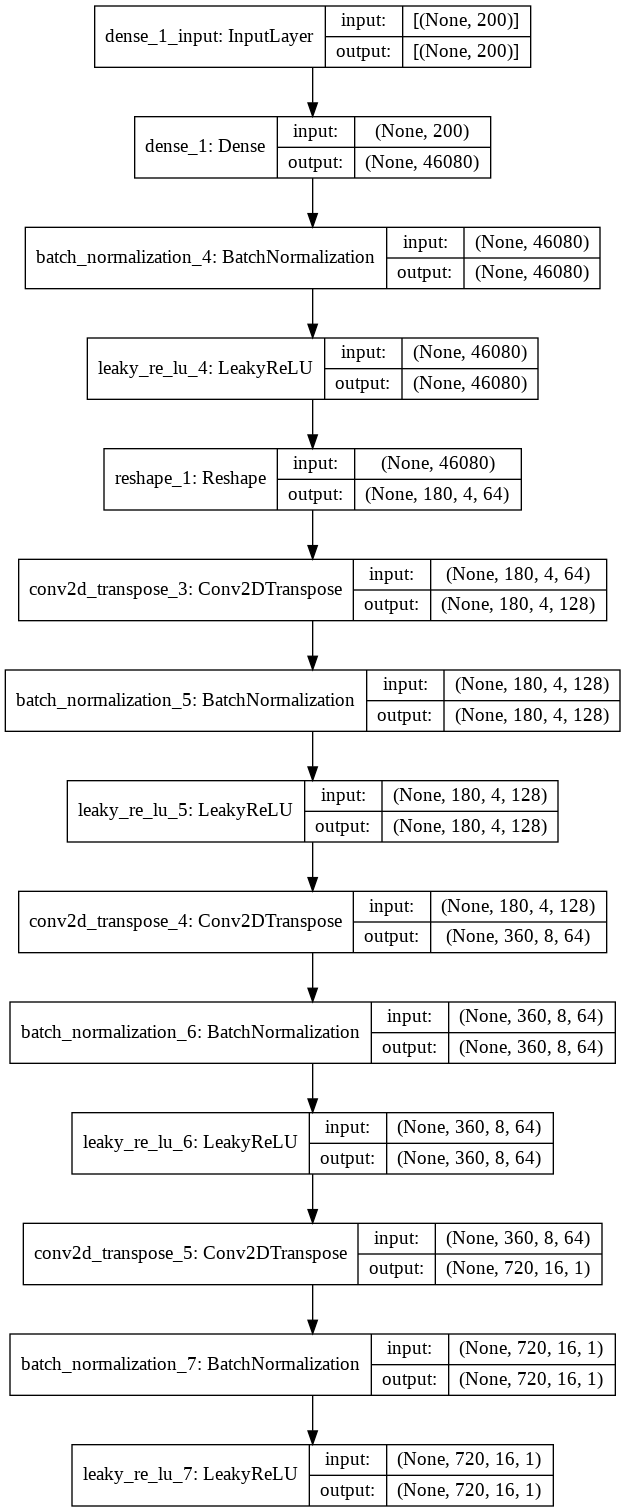

In [19]:
plot_model(G, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
def discriminator_model():
    model = tf.keras.Sequential()
    # First 2D Conv Layer
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[720,16,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Second 2D Conv Layer
    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Flatten the output of the second layer
    model.add(layers.Flatten())
    # Dense layer for scalar output
    model.add(layers.Dense(1))

    return model

D = discriminator_model()

In [21]:
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 8, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 360, 8, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 360, 8, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 4, 128)       204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 180, 4, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 4, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 92160)            

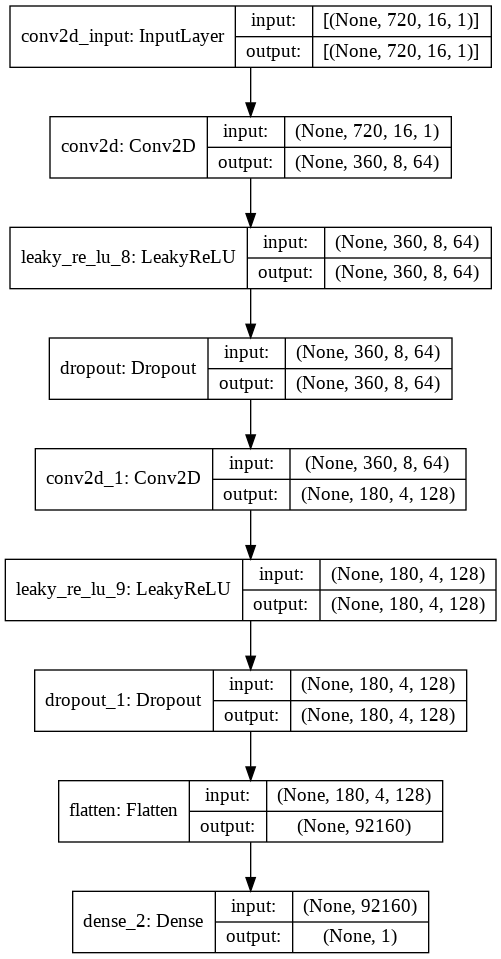

In [22]:
plot_model(D, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
# Defining Binary-Cross-Entropy loss function instance 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Discriminator Loss Function
def discriminator_loss(true_output, fake_output):
    T = cross_entropy(tf.ones_like(true_output), true_output)
    F = cross_entropy(tf.zeros_like(fake_output), fake_output)
    D_loss = F + T
    return D_loss
# Generator Loss Function
def generator_loss(fake_output):
    F = cross_entropy(tf.ones_like(fake_output), fake_output)
    return F

In [25]:
# Defining the number of epochs before the training
Epochs = 500
G_Opt = tf.keras.optimizers.Adam(1e-5)
D_Opt = tf.keras.optimizers.Adam(1e-5)

In [51]:
def input_for_GAN(Batch_Size, ND ,Train_Images, n_Imag):
  N = np.random.randint(0,n_Imag,1)
  M = np.random.randint(0,16,1)
  noise = np.random.normal(size=(Batch_Size, ND))
  for i in range(Batch_Size):
    noise[i,0:100] = np.reshape(Train_Images[N,0:100,M,:],(noise[i,0:100].shape))
    

  return noise


  

In [52]:
A = input_for_GAN(Batch_Size, noise_d, train_imgs, N_Imag)
print(A.shape)

(24, 200)


In [53]:
@tf.function
def train_step(images):
    noise = input_for_GAN(Batch_Size, noise_d, train_imgs, N_Imag)
    noise = tf.convert_to_tensor(noise)
    noise = tf.reshape(noise,([Batch_Size,noise_d]))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Making a Noise generated image through the Generator
        generated_img = G(noise, training=True) 
        # True and Fake outputs from Discriminator
        T_out = D(images, training=True)
        F_out = D(generated_img, training=True)
        # Generator Loss
        G_Loss = generator_loss(F_out)
        # Discriminator Loss
        D_Loss = discriminator_loss(T_out, F_out)
    # Gradient Computation
    grad_gen = gen_tape.gradient(G_Loss, G.trainable_variables)
    grad_disc = disc_tape.gradient(D_Loss, D.trainable_variables)
    # Updating the weights
    G_Opt.apply_gradients(zip(grad_gen, G.trainable_variables))
    D_Opt.apply_gradients(zip(grad_disc, D.trainable_variables))
    # Returning the Losses
    return tf.cast(G_Loss, tf.float32),tf.cast(D_Loss, tf.float32)

In [54]:
def train(dataset, epochs):

    G_Loss_History = []
    D_Loss_History = []
    for epoch in range(epochs):
        
        start = time.time()
        G_Losses = []
        D_Losses = []
        for img_batch in dataset:
            G_Loss, D_Loss = train_step(img_batch)
            # Saving the Loss values in an array for the entire dataset
            G_Losses.append(G_Loss)
            D_Losses.append(D_Loss)
            
        # History of all Loss Function Arrays
        G_Loss_History.append(G_Losses)
        D_Loss_History.append(D_Losses)
        G_Mean = sum(G_Losses)/len(G_Losses)
        D_Mean = sum(D_Losses)/len(D_Losses)
        print("Finished training epoch: ", epoch + 1)
        print("Generator Loss : ", G_Mean.numpy() , "Discriminator Loss : ", D_Mean.numpy())


    # Returning Errors
    return G_Loss_History, D_Loss_History

In [55]:
G_Loss_History, D_Loss_History = train(train_set, Epochs)

Finished training epoch:  1
Generator Loss :  0.43459082 Discriminator Loss :  1.1586454


KeyboardInterrupt: ignored

In [39]:
G_Loss = []
D_Loss = []
for i in range(Epochs):
  G_Loss_i = G_Loss_History[i]
  Mean = sum(G_Loss_i)/len(G_Loss_i)
  G_Loss.append(Mean.numpy())
  D_Loss_i = D_Loss_History[i]
  Mean = sum(D_Loss_i)/len(D_Loss_i)
  D_Loss.append(Mean.numpy())

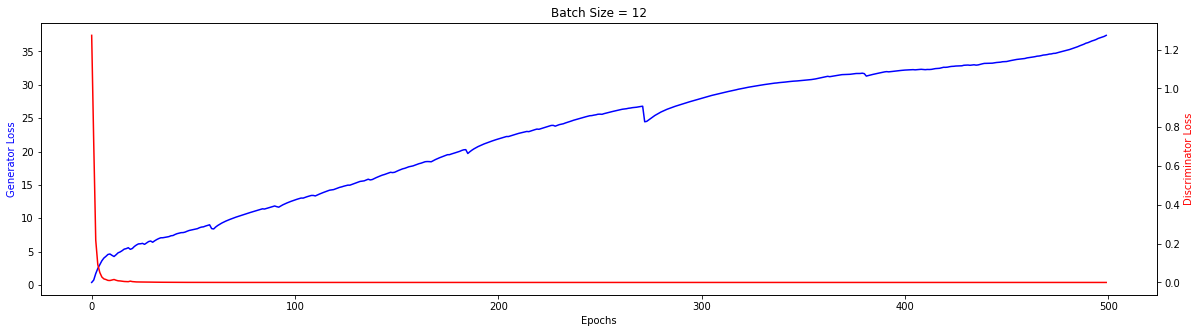

In [40]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(G_Loss, 'b-')
ax1.set_ylabel('Generator Loss', color='b')
ax1.set_xlabel('Epochs',color='k')
ax2 = ax1.twinx()
ax2.plot(D_Loss, 'r-')
ax2.set_ylabel('Discriminator Loss', color='r')
plt.title('Batch Size = 12')
plt.show()

In [41]:
seed = input_for_GAN(Batch_Size, noise_d, train_imgs, N_Imag)
seed = tf.convert_to_tensor(seed)

In [45]:
predictions = G(seed, training=False)
predictions = predictions.numpy()
predictions = np.reshape(predictions,(16,720))
print(predictions.shape)

(16, 720)


In [47]:
df = pd.DataFrame(data=predictions)
df.to_csv("./GAN4_out.csv", sep=',',index=False)